# Replica de la tabla de ingreso promedio trimestral monetario de la ENIGH
1. **Distribución del ingreso.** Histograma con la distribución del ingreso (Poderación de las observaciones utilizando el factor de expansión). 

2. **Percentiles de ingreso.**

    2.1 cálculo de los percertiles de ingreso.
    
    2.2 cálculo del ingreso promedio de cada percentil de ingreso. 
    
    2.3 cálculo del índice de gini para cada percentil de ingreso.

3. **Unir bases de datos.** Replica de la parte correspondiente a 2022 de la tabla de ingreso promedio trimestral monetario por grupos de edad, según sexo y año de levantamiento de la página 20 de la [presentación ejecutiva](https://www.inegi.org.mx/contenidos/programas/enigh/nc/2022/doc/enigh2022_ns_presentacion_resultados.pdf) de la ENIGH 2022.


In [14]:
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np

In [2]:
enigh_completa = pd.read_csv('concentradohogar.csv')

In [3]:
#copia de la base de datos
enigh = enigh_completa.copy()
#Variables que vamos a usar
enigh = enigh[['factor', 'tot_integ', 'percep_ing', 'ocupados', 
               'ing_cor', 'ingtrab', 'transfer', 'estim_alqu', 'rentas', 'otros_ing', 
               'educa_jefe', 'sexo_jefe']]
enigh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90102 entries, 0 to 90101
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   factor      90102 non-null  int64  
 1   tot_integ   90102 non-null  int64  
 2   percep_ing  90102 non-null  int64  
 3   ocupados    90102 non-null  int64  
 4   ing_cor     90102 non-null  float64
 5   ingtrab     90102 non-null  float64
 6   transfer    90102 non-null  float64
 7   estim_alqu  90102 non-null  float64
 8   rentas      90102 non-null  float64
 9   otros_ing   90102 non-null  float64
 10  educa_jefe  90102 non-null  int64  
 11  sexo_jefe   90102 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 8.2 MB


In [4]:
#ingreso trimestral promedio sin factor
enigh.ing_cor.mean()
#Ingreso trimestral promedio con factor
np.average(enigh.ing_cor, weights = enigh.factor)

63695.45790004601

In [5]:
#Sin factor de expansión
deciles = np.linspace(0.1, 1, 10)
np.quantile(enigh.ing_cor, deciles)

array([  18127.934,   25158.61 ,   31589.862,   38360.64 ,   46073.685,
         55232.544,   66895.373,   83843.876,  115839.447, 7153770.46 ])

In [6]:
#Distribución del ingreso corriente total trimestral, por deciles de hogares
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    :ref: https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [7]:
#deciles de ingreso trimestral
deciles_ingreso = weighted_quantile(enigh.ing_cor, deciles, sample_weight = enigh.factor)
deciles_ingreso

array([  18735.250749  ,   25882.44246288,   32517.99      ,
         39448.01510345,   47328.80200873,   56680.31526302,
         68755.82134112,   86372.56018915,  119982.87288889,
       7153770.46      ])

In [8]:
# Para asignar a cada observación el decil correspondiente
cond = [
    enigh.ing_cor <= deciles_ingreso[0],
    (deciles_ingreso[0] < enigh.ing_cor) & (enigh.ing_cor <= deciles_ingreso[1]),
    (deciles_ingreso[1] < enigh.ing_cor) & (enigh.ing_cor <= deciles_ingreso[2]),
    (deciles_ingreso[2] < enigh.ing_cor) & (enigh.ing_cor <= deciles_ingreso[3]),
    (deciles_ingreso[3] < enigh.ing_cor) & (enigh.ing_cor <= deciles_ingreso[4]),
    (deciles_ingreso[4] < enigh.ing_cor) & (enigh.ing_cor <= deciles_ingreso[5]),
    (deciles_ingreso[5] < enigh.ing_cor) & (enigh.ing_cor <= deciles_ingreso[6]),
    (deciles_ingreso[6] < enigh.ing_cor) & (enigh.ing_cor <= deciles_ingreso[7]),
    (deciles_ingreso[7] < enigh.ing_cor) & (enigh.ing_cor <= deciles_ingreso[8]),
    (deciles_ingreso[8] < enigh.ing_cor) & (enigh.ing_cor <= deciles_ingreso[9])
]

asigna = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
enigh['decil_ing'] = np.select(cond, asigna)

In [9]:
enigh.head()

,factor,tot_integ,percep_ing,ocupados,ing_cor,ingtrab,transfer,estim_alqu,rentas,otros_ing,educa_jefe,sexo_jefe,decil_ing
0,206,3,3,1,56123.75,35706.51,8804.34,11612.90,0.00,0.0,3,2,6
1,206,2,2,2,108048.87,66766.28,8999.99,0.00,32282.60,0.0,8,1,9
2,206,3,2,2,133852.88,93081.50,0.00,29032.25,11739.13,0.0,10,1,10
3,167,4,2,0,105054.15,0.00,90538.03,14516.12,0.00,0.0,11,1,9
4,167,1,1,1,24211.95,22255.43,1956.52,0.00,0.00,0.0,8,1,2


In [10]:
#calcule los percertiles de ingreso
wm = lambda x: np.average(x, weights=enigh.loc[x.index, "factor"])
enigh.groupby(['decil_ing']).agg(ingreso_promedio = ("ing_cor", wm)).style.format("${:,.0f}")

,ingreso_promedio
decil_ing,
1,"$13,412"
2,"$22,422"
3,"$29,201"
4,"$35,948"
5,"$43,341"
6,"$51,924"
7,"$62,411"
8,"$76,736"
9,"$100,866"


AttributeError: 'AxesSubplot' object has no attribute 'style'

<Figure size 737.28x552.96 with 0 Axes>

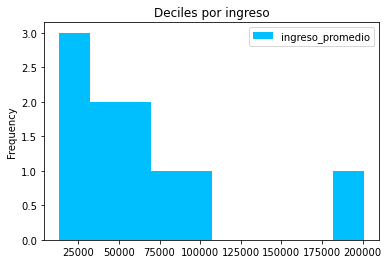

In [21]:
#Realice un histograma con la distribución del ingreso
plot.figure(figsize = (10.24, 7.68))
wm = lambda x: np.average(x, weights=enigh.loc[x.index, "factor"])
enigh.groupby(['decil_ing']).agg(ingreso_promedio = ("ing_cor", wm)).plot(kind = 'hist', color = 'deepskyblue', title = 'Deciles por ingreso', ylabel = 'Ingreso').style.format("${:,.0f}")
plot.show()

In [22]:
def gini(x, w=None):
    # source: https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

In [25]:
#calcule el índice de gini para cada percentil de ingreso.
gini(enigh.ing_cor, enigh.factor)

0.4126766233060339